# Hakai Profile QA/QC Development Tool
This jupyter notebook is a flexible tool used for testing and improving Hakai's QA/QCing workflow of the its CTD profile data. 

The tool can load Hakai's CTD dataset and apply default tests already applied. Those tests can be modified by the user to tests different thresholds. Other tests can be added too!

## Let's load all the python packages we need
This may take some times the very first time. Some of the packages are available through Pypi while others aren't. We also load the hakai_qc main branch here.

We also install the ioos_qc tool from the Hakai github fork and add-density-inversion-test branch. This will likely change in th future as some new tests gets integrated int he standard ioos_qc package.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Get External packages
try:
    from hakai_api import Client
    from ioos_qc.config import QcConfig
    import hakai_qc
except:
    # Install Hakai API Python Client
    !pip install git+https://github.com/HakaiInstitute/hakai-api-client-python.git
    from hakai_api import Client

    # Install ioos_qc
    !pip install git+https://github.com/HakaiInstitute/ioos_qc@add-density-inversion-test
    from ioos_qc.config import QcConfig
    
    # Load local modules
    !pip install git+https://github.com/HakaiInstitute/hakai-profile-qaqc.git
    import hakai_qc


## Import data from the Hakai CTD Profile Database and Hakai List of Stations
The Hakai Station Master List is based on a CSV output of the [Hakai Oceanography Master Stations Map and Data](https://hakai.maps.arcgis.com/apps/webappviewer/index.html?id=38e1b1da8d16466bbe5d7c7a713d2678). Missing sites should be added to the master list in order to applied all the different tests.

In [2]:
# Load Hakai Station List
hakai_stations = hakai_qc.get.hakai_stations()

Now, let's get some data from the Hakai CTD Processed Data Database 

In [3]:
# Get Hakai CTD Data Download through the API
# Let's just get the data from QU39
year = 2016
filterUrl = 'station=QU39&status!=MISCAST&limit=-1'+'&measurement_dt>'+str(year)+'-01-01&measurement_dt<'+str(year+1)+'-01-01'
#filterUrl = 'station=QU39&status!=MISCAST&limit=-1'+fields
df, url = hakai_qc.get.hakai_ctd_data(filterUrl)
print(str(len(df))+' records found')

# Regroup profiles and sort them by pressure
group_variables = ['device_model','device_sn','ctd_file_pk','ctd_cast_pk','direction_flag']
df = df.sort_values(by=group_variables+['pressure'])

# Get Derived Variables
df = hakai_qc.utils.derived_ocean_variables(df)

# Just show the first few lines to have a look
df.head() # Show the top of the data frame

34270 records found


C:\Users\jessy\Anaconda3\lib\site-packages\gsw\_wrapped_ufuncs.py:696: RuntimeWarning: invalid value encountered in ct_from_t
  return _gsw_ufuncs.ct_from_t(SA, t, p)


,ctd_file_pk,ctd_cast_pk,hakai_id,ctd_data_pk,filename,device_model,device_sn,device_firmware,file_processing_stage,work_area,...,cast_type,sensors_submerged,water_depth_m,soak_start,soak_end,weather,absolute salinity,conservative temperature,density,sigma0
31088,2747,8039,080217_2016-12-03T17:13:56.333Z,9189085,080217_20161203_1513,RBRconcerto,080217,12.040,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,25.948494,9.076951,1019.960540,19.955942
31338,2747,8039,080217_2016-12-03T17:13:56.333Z,9189086,080217_20161203_1513,RBRconcerto,080217,12.040,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,25.967442,9.087087,1019.978438,19.969243
31339,2747,8039,080217_2016-12-03T17:13:56.333Z,9189087,080217_20161203_1513,RBRconcerto,080217,12.040,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.028492,9.127229,1020.024841,20.011053
31340,2747,8039,080217_2016-12-03T17:13:56.333Z,9189088,080217_20161203_1513,RBRconcerto,080217,12.040,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.098888,9.183102,1020.076274,20.057897
31341,2747,8039,080217_2016-12-03T17:13:56.333Z,9189089,080217_20161203_1513,RBRconcerto,080217,12.040,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.278609,9.280932,1020.206486,20.183533


## Test Configuration
We first import the different tests that applied as of now to the Hakai Dataset. You can also add new tests by adding a related dictionary which follow the structure presented below. For more information on the different tests available, have a look at the [ioos_qc webpage](https://ioos.github.io/ioos_qc/api/ioos_qc.html).

In [4]:
# Load default test parameters used right now!
qc_config = hakai_qc.get.json_config('hakai_ctd_profile.json')

# If you want to add or modify some of the tests do it here
#ex: let's add for the range of fluorescence 
qc_config['flc']= {'qartod': {
                        'gross_range_test': {   
                            "suspect_span": [0, 70],
                            "fail_span": [-.5, 100],
                        },
    
                        "aggregate": {}    
                        }
                   }
# Show the QC config in a nice looking table
hakai_qc.get.config_as_dataframe(qc_config)

Value
Variable              Module Test                   Input                                              
position              qartod location_test          bbox                           [-180, -90, 180, 90]
                                                    range                                          3000
pressure              qartod gross_range_test       suspect_span                             [0, 12000]
                                                    fail_span                                [0, 12000]
                                                    maximum_suspect_depth_ratio                    1.05
                                                    maximum_fail_depth_ratio                        1.1
depth                 qartod gross_range_test       suspect_span                             [0, 12000]
                                                    fail_span                                [0, 12000]
                                                    maximum_suspect_depth_ratio                    1.05
                                                    maximum_fail_depth_ratio                        1.1
dissolved_oxygen_ml_l qartod gross_range_test       fail_span                                   [0, 12]
                                                    suspect_span                                [1, 10]
                             rate_of_change_test    threshold                                         1
                             spike_test             suspect_threshold                               0.5
                                                    fail_threshold                                    1
                             attenuated_signal_test suspect_threshold                               0.5
                                                    fail_threshold                                  0.2
                                                    check_type                                    range
rinko_do_ml_l         qartod gross_range_test       fail_span                                   [0, 12]
                                                    suspect_span                                [1, 10]
                             rate_of_change_test    threshold                                         1
                             spike_test             suspect_threshold                               0.5
                                                    fail_threshold                                    1
                             attenuated_signal_test suspect_threshold                               0.5
                                                    fail_threshold                                  0.2
                                                    check_type                                    range
turbidity             qartod gross_range_test       fail_span                             [-0.1, 10000]
                                                    suspect_span                              [0, 1000]
                             attenuated_signal_test suspect_threshold                               0.1
                                                    fail_threshold                                 0.02
                                                    check_type                                    range
c_star_at             qartod attenuated_signal_test suspect_threshold                             0.002
                                                    fail_threshold                               0.0001
                                                    check_type                                    range
                             spike_test             suspect_threshold                              0.05
                                                    fail_threshold                                  0.5
par                   qartod gross_range_test       fail_span                            [-0.2, 100000]
                                          

## Run Test on Data
All the different tests listed above are applied to station and each profiles one at the time. 


In [5]:
# Run all the tests on each available profiles
df = hakai_qc.run.tests_on_profiles(df,hakai_stations,qc_config)

QAQC QU39
  position
    qartod
      ('location_test', {'bbox': [-125.14107014641213, 50.00372871260039, -125.05732985358786, 50.05767116137374], 'range': 3000})
      ('aggregate', {})
  pressure
    qartod
      ('gross_range_test', {'suspect_span': [0, 280.83826311944904], 'fail_span': [0, 294.2115137441847], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1})
      ('aggregate', {})
  depth
    qartod
      ('gross_range_test', {'suspect_span': [0, 278.25], 'fail_span': [0, 291.5], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1})
      ('aggregate', {})
  dissolved_oxygen_ml_l
    qartod
      ('gross_range_test', {'fail_span': [0, 12], 'suspect_span': [1, 10]})
      ('rate_of_change_test', {'threshold': 1})
      ('spike_test', {'suspect_threshold': 0.5, 'fail_threshold': 1})
      ('attenuated_signal_test', {'suspect_threshold': 0.5, 'fail_threshold': 0.2, 'check_type': 'range'})
      ('aggregate', {})
  rinko_do_ml_l
    qartod
      (

## Review Results
Let's filter all the data that actually got flagged and keep only the downcast.

In [18]:
# Get Variables to plot (first line gives a list of a the variables that are tested, the second overwrite the first if you want to look into one or few specific variables)
variables_to_plot = list(set(qc_config.keys())-set(['position','depth','pressure']))
variables_to_plot = ["dissolved_oxygen_ml_l","rinko_do_ml_l"]

# Review Flagged data (let's look at only the downcast)
flag_columns = [var+'_qartod_aggregate' for var in variables_to_plot]
flagged_hakai_id = df[df['direction_flag']=='d'][((df.filter(items=flag_columns)>1) 
                       & (df.filter(items=flag_columns)!=9)).any(axis=1)]['hakai_id'].unique()              

# Tell me how many there is
print(str(len(flagged_hakai_id))+' profiles were flagged')

24 profiles were flagged


C:\Users\jessy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


080217_2016-11-26T17:24:19.333Z
080217_2016-11-26T20:23:06.500Z
080217_2016-01-04T20:21:09.667Z
080217_2016-02-02T19:39:21.000Z
080217_2016-02-09T20:12:48.667Z
01907674_2016-03-31T16:33:20Z
01907674_2016-04-01T17:26:14Z
01907674_2016-04-04T17:48:38Z
01907674_2016-04-27T17:37:15Z
01907674_2016-05-06T16:00:07Z
01907674_2016-05-08T19:33:00Z
01907674_2016-05-19T14:53:17Z
01907674_2016-05-29T18:54:44Z
01907674_2016-08-01T16:15:42Z
01907674_2016-08-18T16:55:12Z
01907674_2016-09-20T17:45:13Z
01907674_2016-10-12T16:23:36Z
01907674_2016-10-22T17:41:55Z
01907674_2016-10-24T16:54:02Z
01907674_2016-10-12T17:57:32Z
01907674_2016-11-09T18:03:00Z
01907674_2016-11-14T19:01:40Z
01907674_2016-11-09T20:05:02Z
01907674_2016-11-10T18:18:36Z


<Figure size 432x288 with 0 Axes>

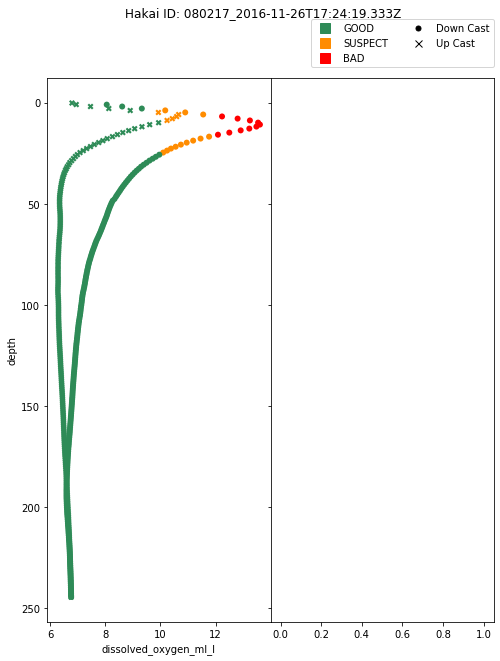

<Figure size 432x288 with 0 Axes>

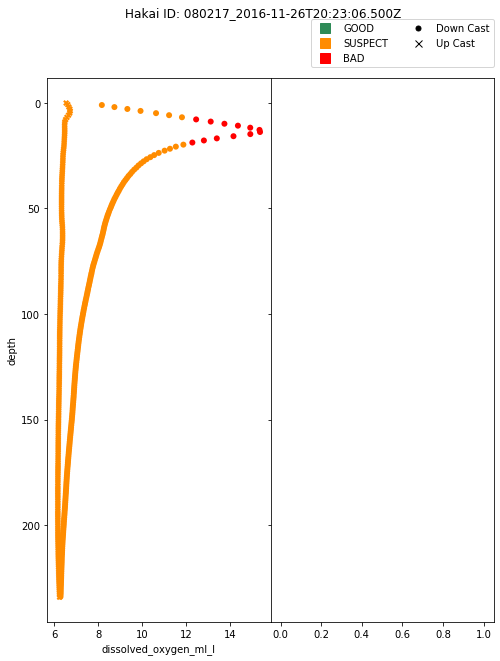

<Figure size 432x288 with 0 Axes>

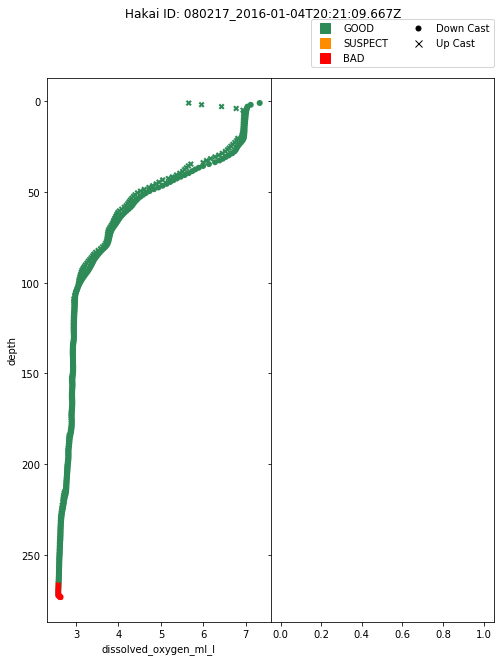

<Figure size 432x288 with 0 Axes>

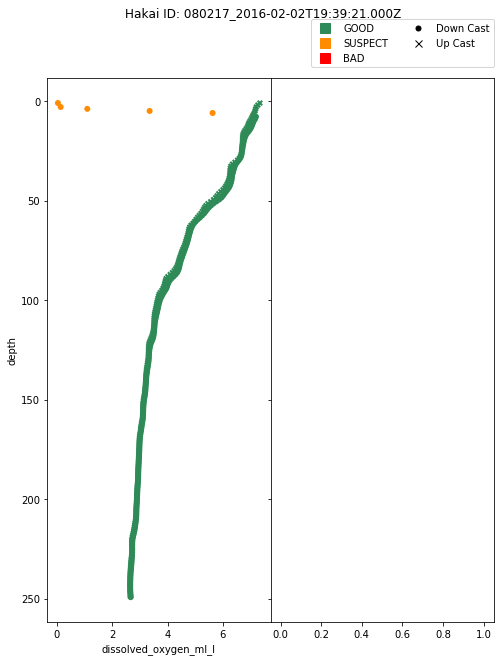

<Figure size 432x288 with 0 Axes>

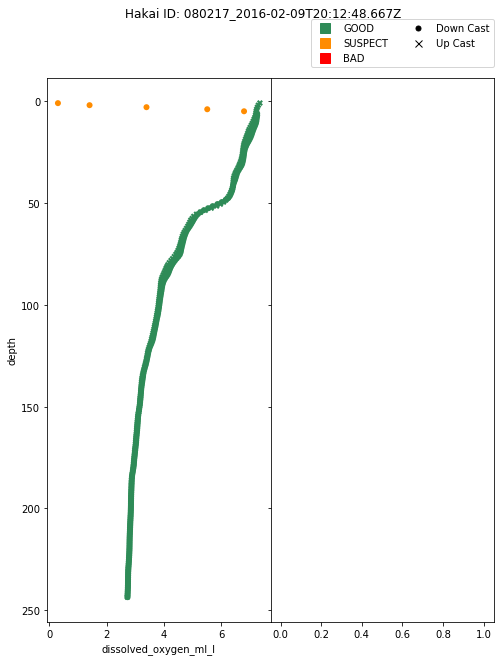

<Figure size 432x288 with 0 Axes>

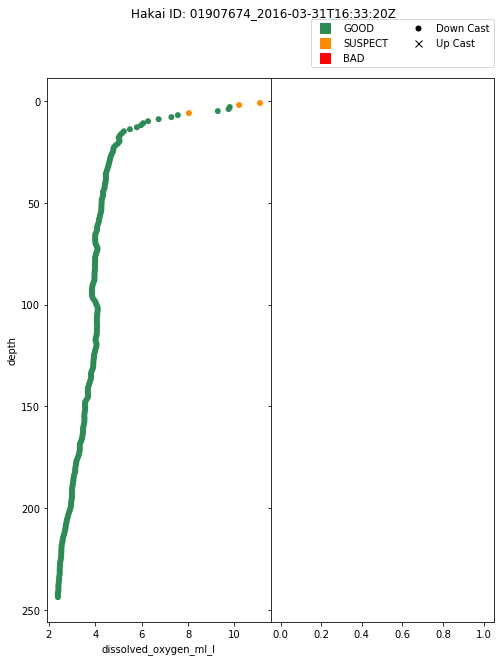

<Figure size 432x288 with 0 Axes>

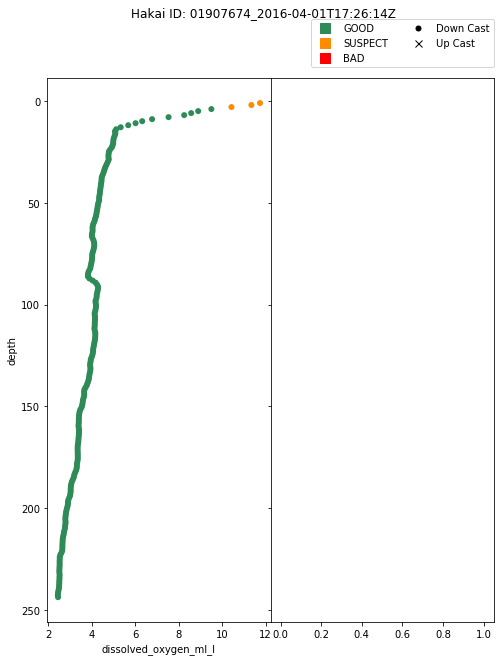

<Figure size 432x288 with 0 Axes>

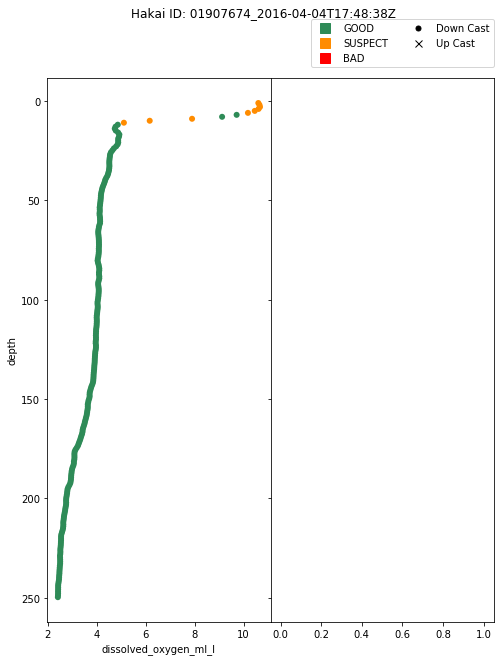

<Figure size 432x288 with 0 Axes>

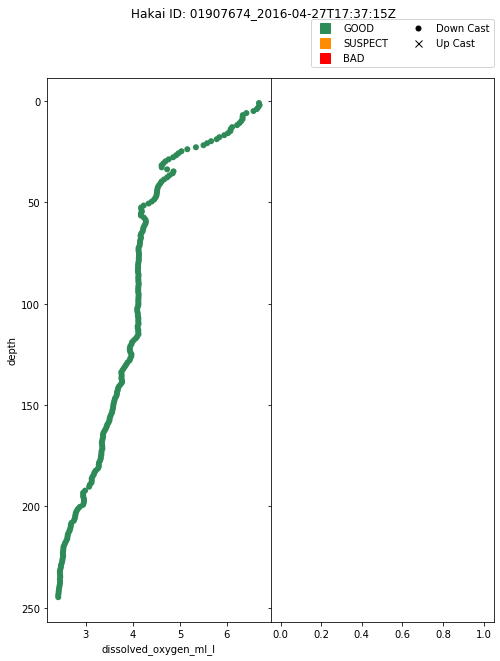

<Figure size 432x288 with 0 Axes>

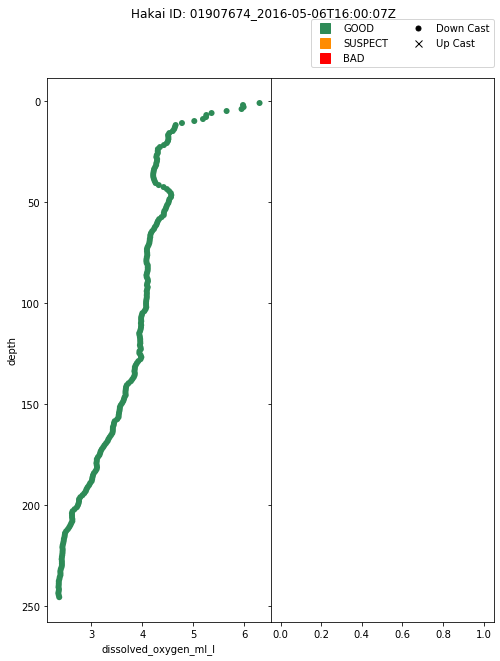

<Figure size 432x288 with 0 Axes>

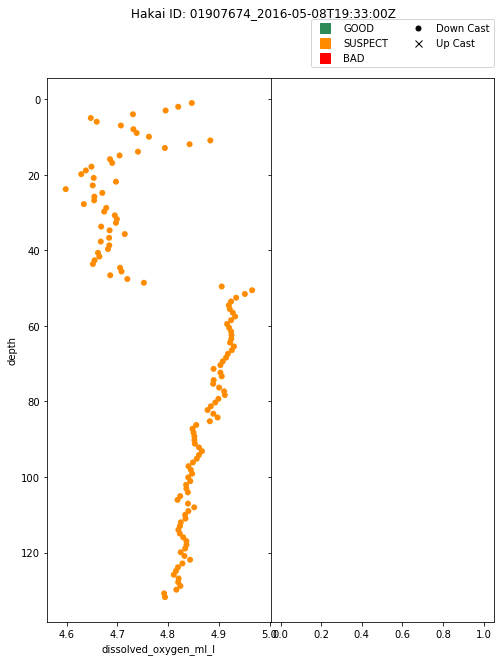

<Figure size 432x288 with 0 Axes>

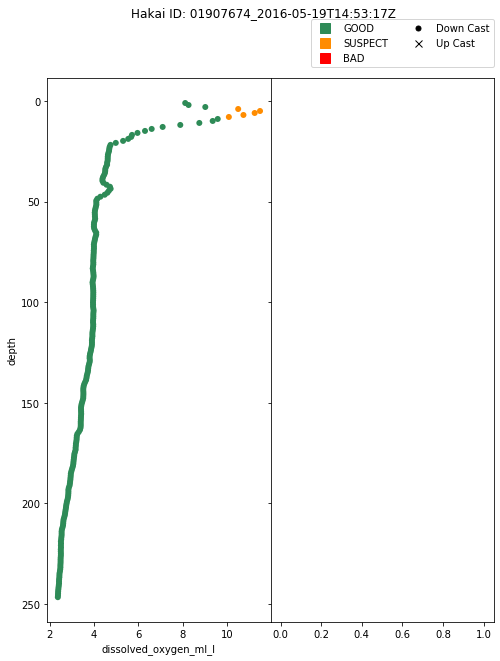

<Figure size 432x288 with 0 Axes>

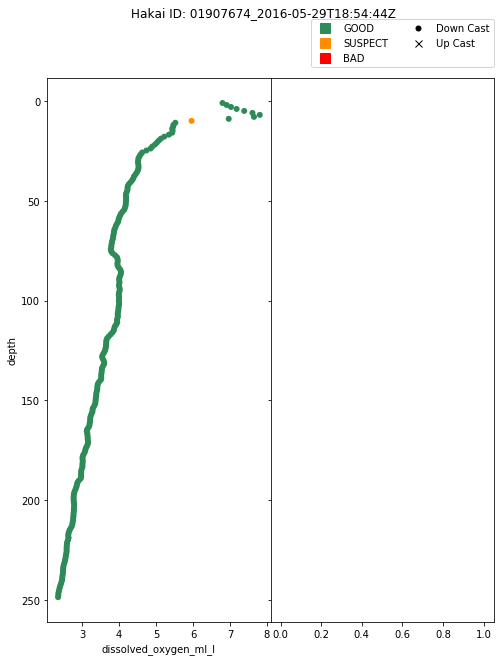

<Figure size 432x288 with 0 Axes>

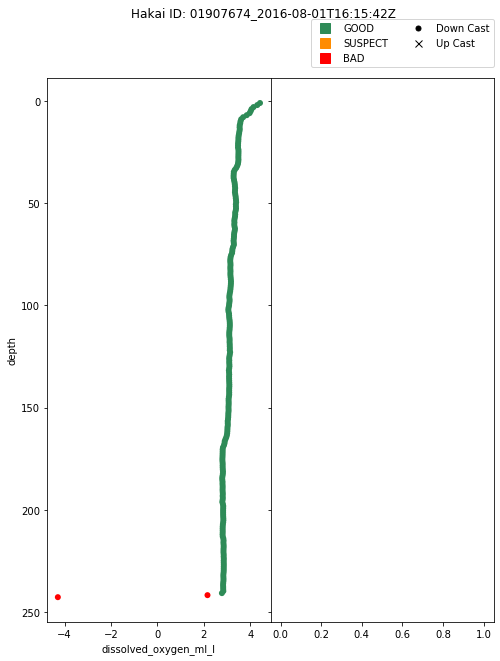

<Figure size 432x288 with 0 Axes>

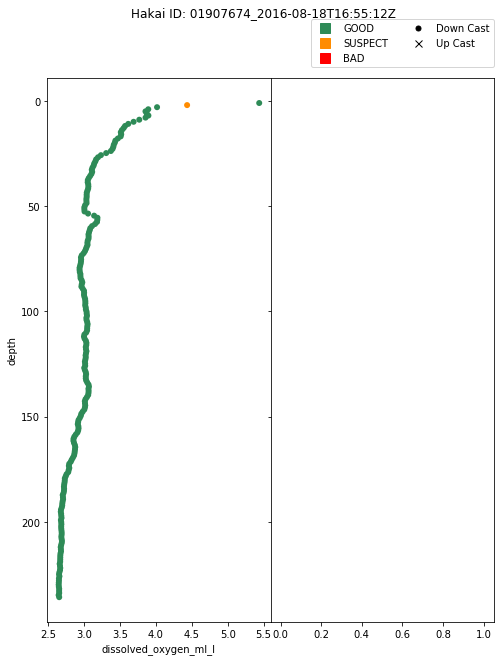

<Figure size 432x288 with 0 Axes>

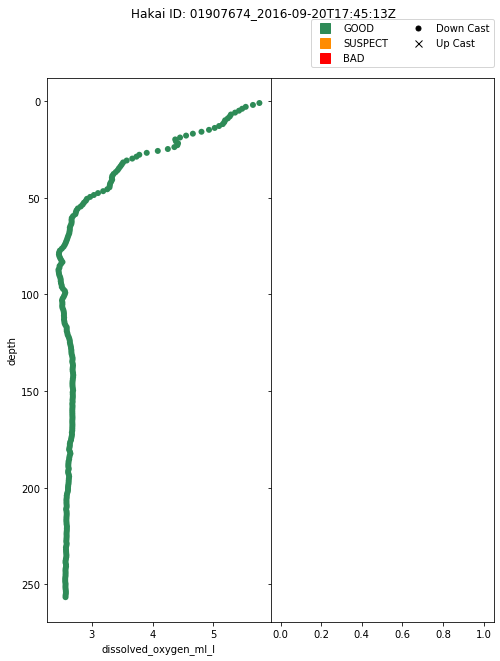

<Figure size 432x288 with 0 Axes>

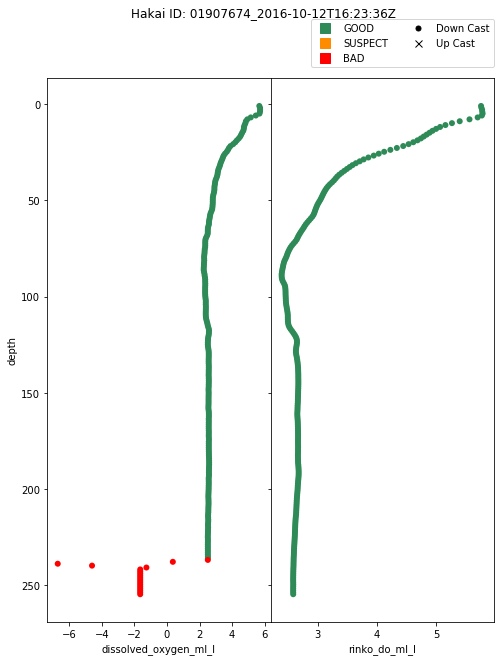

<Figure size 432x288 with 0 Axes>

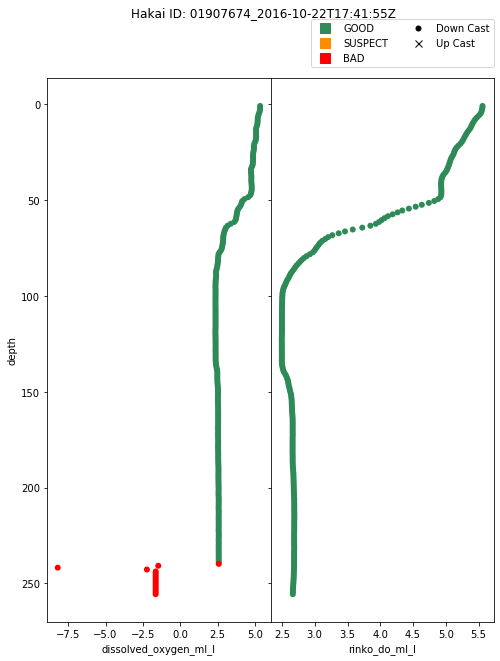

<Figure size 432x288 with 0 Axes>

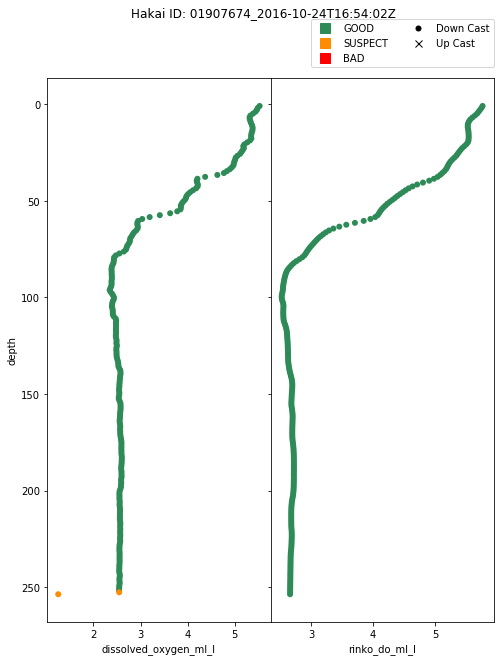

<Figure size 432x288 with 0 Axes>

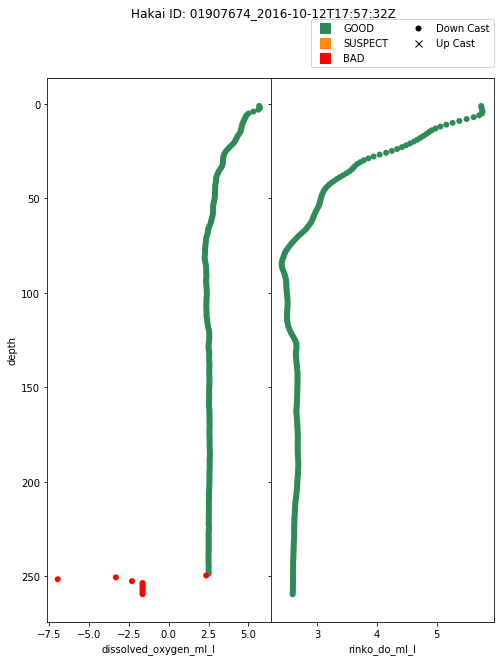

<Figure size 432x288 with 0 Axes>

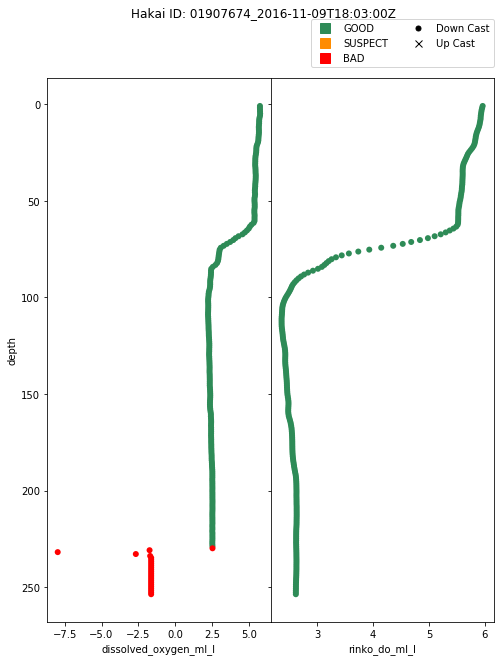

<Figure size 432x288 with 0 Axes>

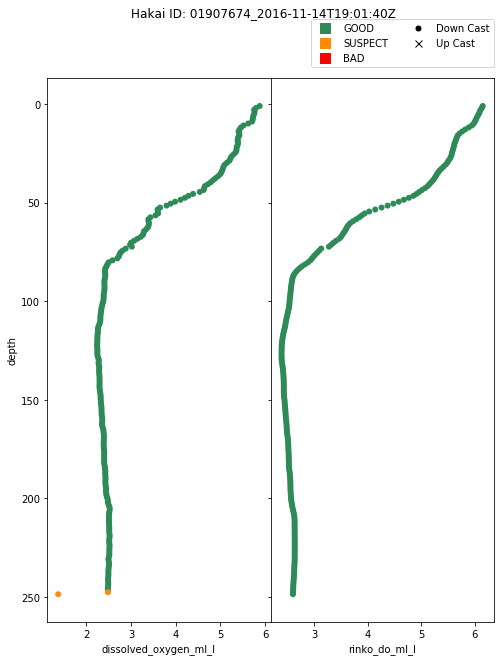

<Figure size 432x288 with 0 Axes>

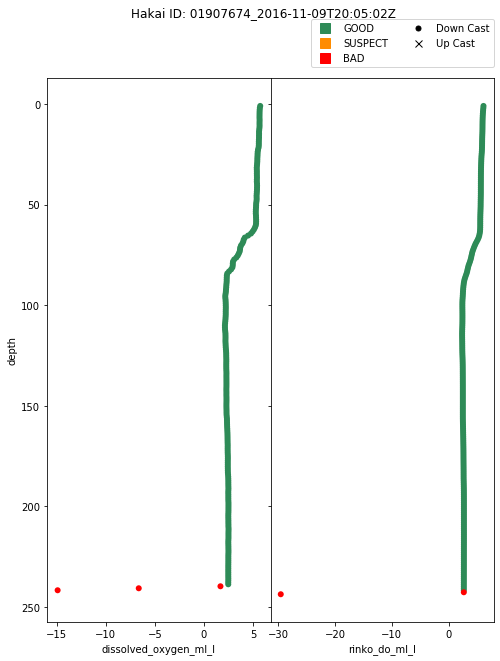

<Figure size 432x288 with 0 Axes>

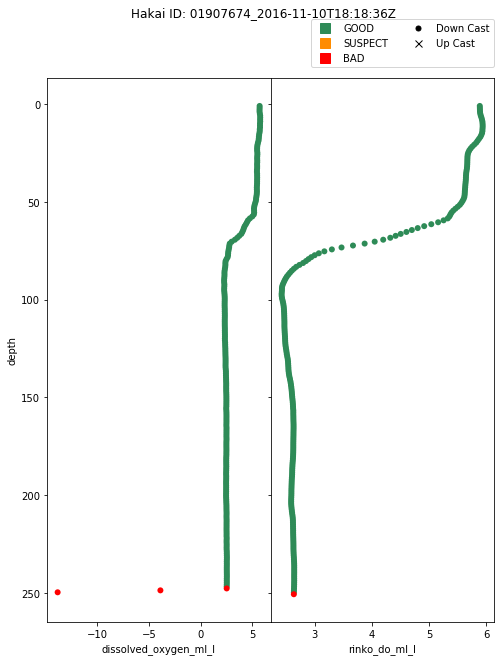

In [21]:
hakai_qc.get.plot_flag_results(df,variables_to_plot,flagged_hakai_id)

Show me the results in a some figures!